<a href="https://colab.research.google.com/github/pgdinamica/deeplearning/blob/main/notebooks/PrimeiraGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Generativas Adversárias (GAN) do zero | Deep Learning com PyTorch

Material da live realizada no canal Programação Dinâmica no dia 13 de novembro de 2021. Confira a gravação completa abaixo.

In [ ]:
from IPython.display import HTML
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/BIEBJZ_Db7Y" 
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

# O que são GANs?

* [Artigo original (Goodfellow, 2014)](https://arxiv.org/abs/1406.2661)
* [StyleGAN3](https://nvlabs.github.io/stylegan3/)
* [GauGAN](https://blogs.nvidia.com/blog/2019/03/18/gaugan-photorealistic-landscapes-nvidia-research/)

# Nosso conjunto de dados

In [ ]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from IPython import display

In [ ]:
imgsize = 28
batch_size = 128
DATA_DIR = '/content/drive/MyDrive/workspace'
IMG_DIR = os.path.join(DATA_DIR, 'results')

In [ ]:
fashiontransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(
         (0.5), (0.5)
     )
     ]
)

fashiondata = datasets.FashionMNIST(DATA_DIR, 
                                    transform=fashiontransform,
                                    download=True)
dataloader = DataLoader(fashiondata, 
                        batch_size=batch_size,
                        shuffle=True)

In [ ]:
def lookat_dataset(dataset, pilimg=False):
    figure = plt.figure(figsize=(16, 4))
    rows, cols = 2, 8
    for i in range(1, 17):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        if pilimg:
            plt.imshow(img)
        else:
            img = (img.squeeze() * 0.5) + 0.5
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')  
            else:
                plt.imshow(img.permute(1, 2, 0))
    plt.show()

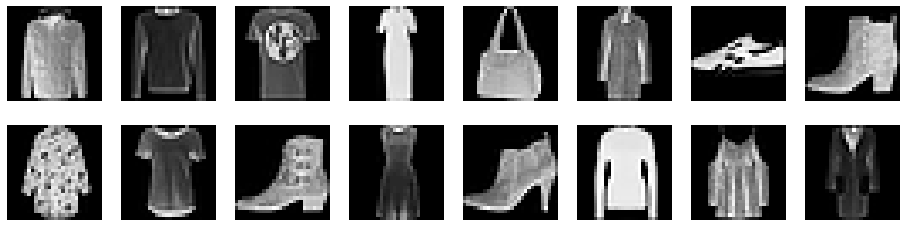

In [ ]:
lookat_dataset(fashiondata)

# Arquitetura das Redes

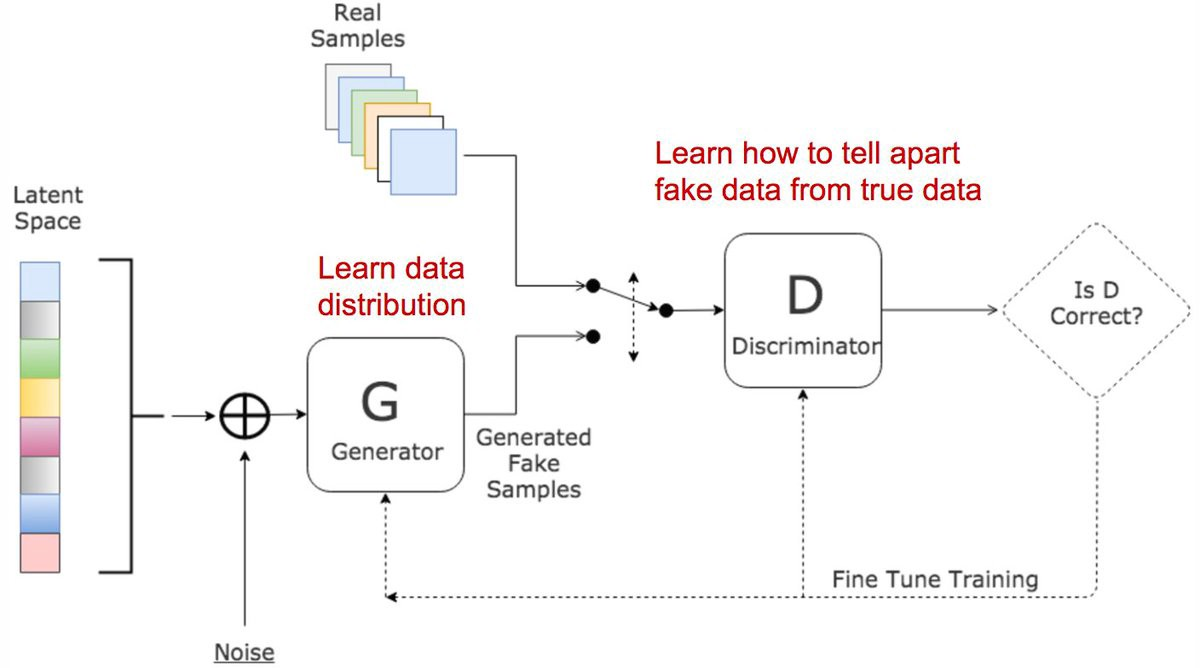

In [ ]:
class Generator(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(n_in, 256),
        nn.LeakyReLU(),

        nn.Linear(256, 512),
        nn.LeakyReLU(),

        nn.Linear(512, 1024),
        nn.LeakyReLU(),
        
        nn.Linear(1024, n_out),
        nn.Tanh()
    )
  
  def forward(self, z):
    return self.layers(z)

class Discriminator(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        n_out = 1
        
        self.layers = nn.Sequential( 
            nn.Linear(n_in, 1024),
            nn.LeakyReLU(0.2),
        
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
        
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [ ]:
noise_dim = 100
generator = Generator(noise_dim, imgsize * imgsize).to(device)
discriminator = Discriminator(imgsize * imgsize).to(device)

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), imgsize * imgsize)

def vectors_to_images(vectors, nc=1):
    return vectors.view(vectors.size(0), nc, imgsize, imgsize)

def noise(size, dim=noise_dim, device=device):
  return torch.randn(size, dim).to(device)

# Visualization
def log_images(test_images, savepath=None):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace=-0.08, hspace=0.01)
  rows, cols = len(test_images)//4, 4
  for i, img in enumerate(test_images):
      figure.add_subplot(rows, cols, i+1)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap='gray')  

  if savepath is not None:
    figure.savefig(savepath)
  plt.show()

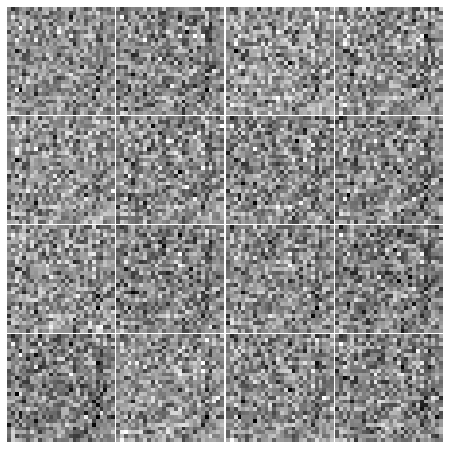

In [ ]:
num_test_samples = 16
torch.manual_seed(7777)
test_noise = noise(num_test_samples, noise_dim)
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')

log_images(
    vectors_to_images(
        generator(test_noise)).cpu().detach().numpy(),
        imagepath
)

# Treinamento

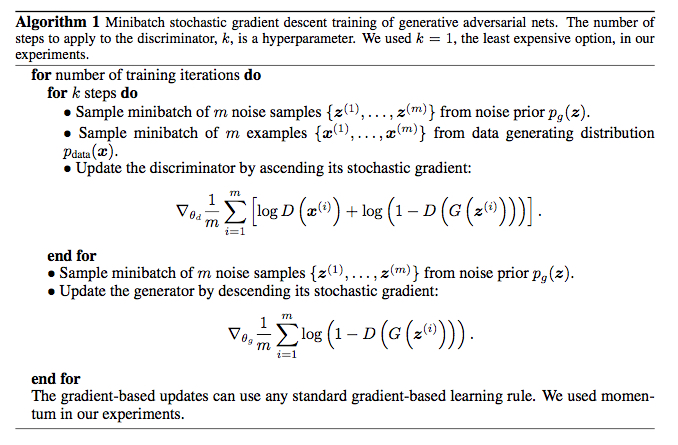

We want to optimize:

$$\begin{align*} 
\min_{G} \max_{D} V(D, G) = E_{x∼p_{data}(x)}[logD(x)] + E_{z∼p_z(z)}[log(1 −D(G(z)))]
\end{align*}$$

In PyTorch, we can implement it in terms of Binary Cross Entropy:

## $$−[y_nlog(\hat{y}_n) +(1−y_n)log(1−\hat{y}_n)]$$


* [BCELoss PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

When we have **real data**, $y_n=1$, $\hat{y_n}=D(x_n)$ and we stay with:

## $$−log(D(x_n)) $$

On the other hand, when we have **fake data**, $y_n=0$, $\hat{y}_n=D(G(z_n))$ and we stay with:

## $$−log(1−D(G(z_n)))$$

In [ ]:
def real_data_target(size, device=device):
  return torch.ones(size, 1).to(device)

def fake_data_target(size, device=device):
  return torch.zeros(size, 1).to(device)

In [ ]:
lr = 0.0002
g_optimizer = optim.Adam(generator.parameters(),
                         lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(),
                         lr=lr)
loss = nn.BCELoss()

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  optimizer.zero_grad()

  pred_real = discriminator(real_data)

  # só a parte referente aos dados reais
  error_real = loss(pred_real, 
                    real_data_target(real_data.size(0)))
  error_real.backward()

  pred_fake = discriminator(fake_data)
  error_fake = loss(pred_fake,
                    fake_data_target(fake_data.size(0)))
  error_fake.backward()

  optimizer.step()

  return error_real + error_fake, pred_real, pred_fake


def train_generator(optimizer, fake_data):
  optimizer.zero_grad()

  pred = discriminator(fake_data)
  error = loss(pred, 
               real_data_target(pred.size(0)))
  error.backward()
  optimizer.step()

  return error

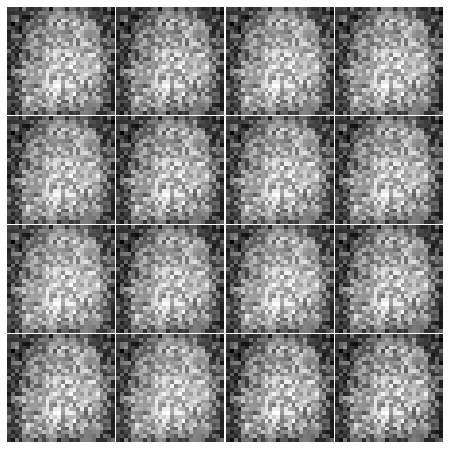

Epoch: 0/20 Losses:
Discriminator: 1.0669; Generator: 3.3123
D(x): 0.8253; D(G(z)): 0.1565


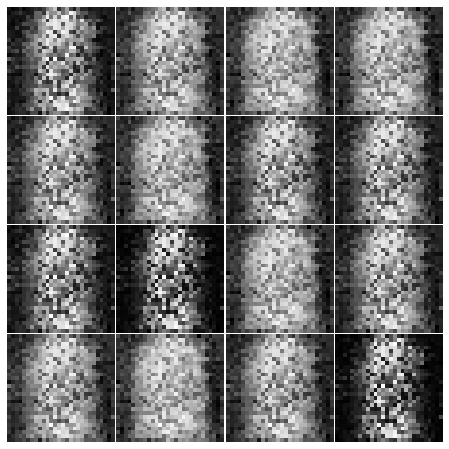

Epoch: 1/20 Losses:
Discriminator: 0.1668; Generator: 6.0874
D(x): 0.9709; D(G(z)): 0.0921


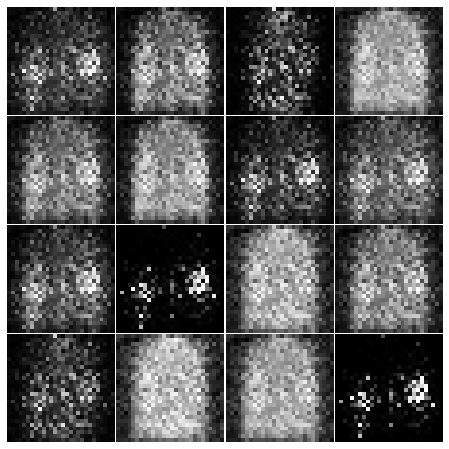

Epoch: 2/20 Losses:
Discriminator: 0.9116; Generator: 5.9636
D(x): 0.8484; D(G(z)): 0.1635


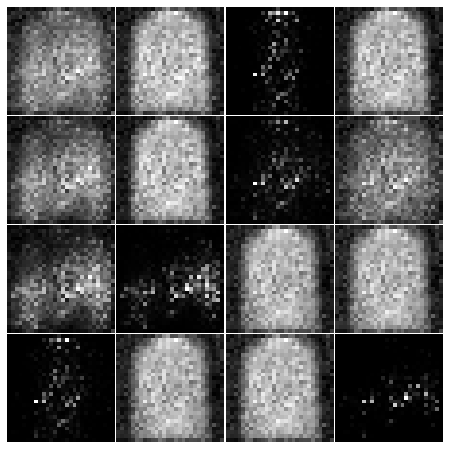

Epoch: 3/20 Losses:
Discriminator: 0.4307; Generator: 3.8037
D(x): 0.8772; D(G(z)): 0.1152


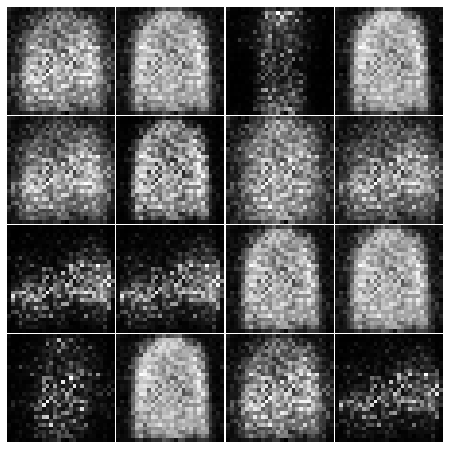

Epoch: 4/20 Losses:
Discriminator: 0.2373; Generator: 3.8591
D(x): 0.9246; D(G(z)): 0.0599


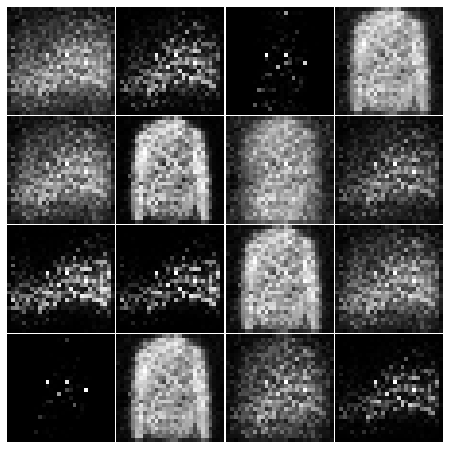

Epoch: 5/20 Losses:
Discriminator: 0.2616; Generator: 4.2814
D(x): 0.9065; D(G(z)): 0.0355


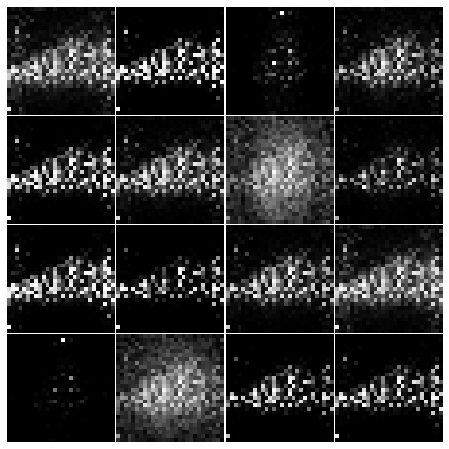

Epoch: 6/20 Losses:
Discriminator: 0.2036; Generator: 4.1587
D(x): 0.9367; D(G(z)): 0.0470


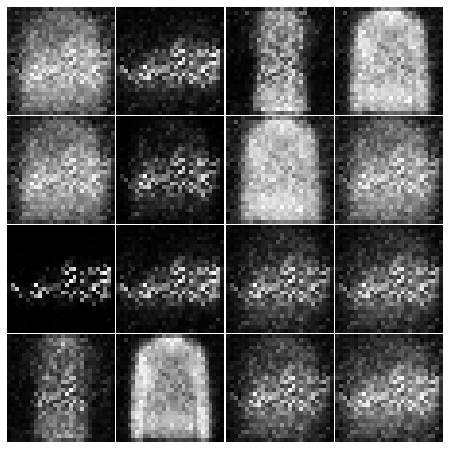

Epoch: 7/20 Losses:
Discriminator: 0.1035; Generator: 4.1685
D(x): 0.9678; D(G(z)): 0.0491


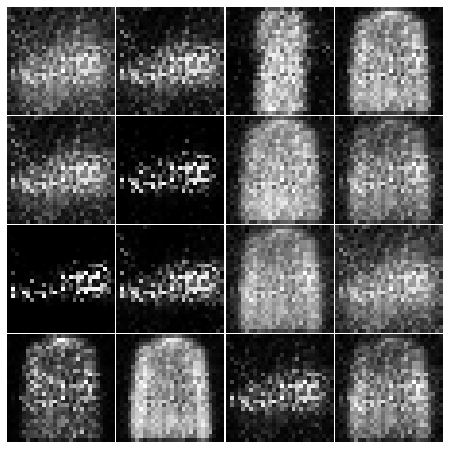

Epoch: 8/20 Losses:
Discriminator: 0.5680; Generator: 4.7500
D(x): 0.9199; D(G(z)): 0.1929


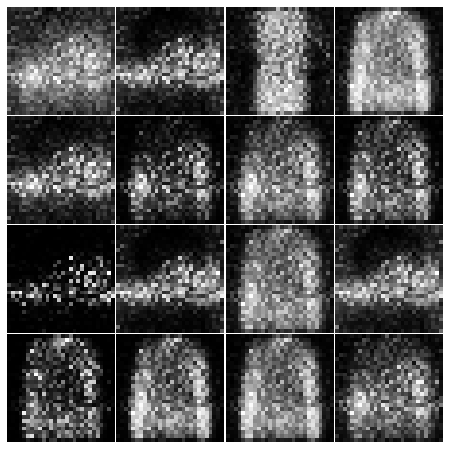

Epoch: 9/20 Losses:
Discriminator: 0.4780; Generator: 3.6732
D(x): 0.9002; D(G(z)): 0.0999


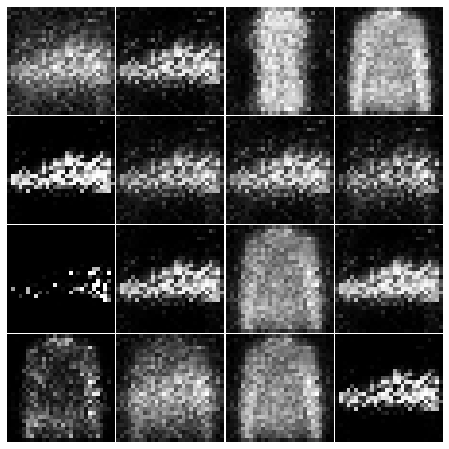

Epoch: 10/20 Losses:
Discriminator: 0.5922; Generator: 3.7901
D(x): 0.9001; D(G(z)): 0.2071


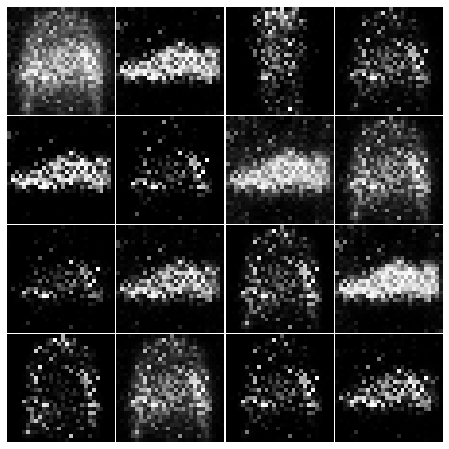

Epoch: 11/20 Losses:
Discriminator: 0.2813; Generator: 3.4854
D(x): 0.9046; D(G(z)): 0.0427


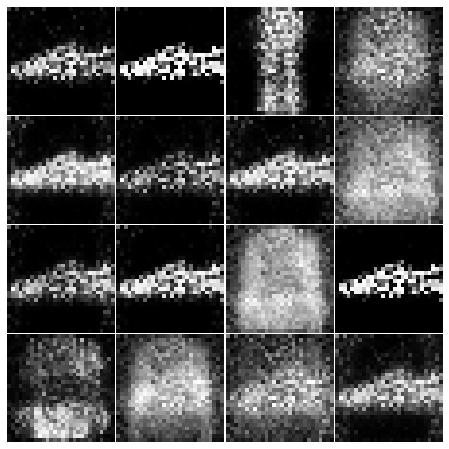

Epoch: 12/20 Losses:
Discriminator: 0.3040; Generator: 4.1535
D(x): 0.9066; D(G(z)): 0.0414


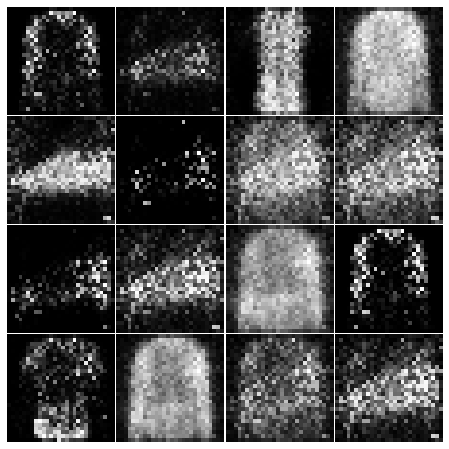

Epoch: 13/20 Losses:
Discriminator: 0.2779; Generator: 6.5706
D(x): 0.9188; D(G(z)): 0.0397


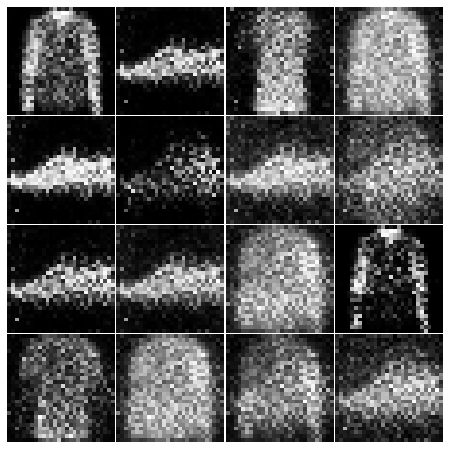

Epoch: 14/20 Losses:
Discriminator: 0.2076; Generator: 3.9591
D(x): 0.9519; D(G(z)): 0.1152


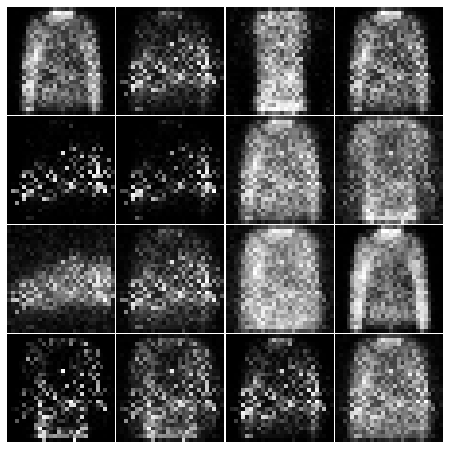

Epoch: 15/20 Losses:
Discriminator: 0.4179; Generator: 3.3684
D(x): 0.8643; D(G(z)): 0.1034


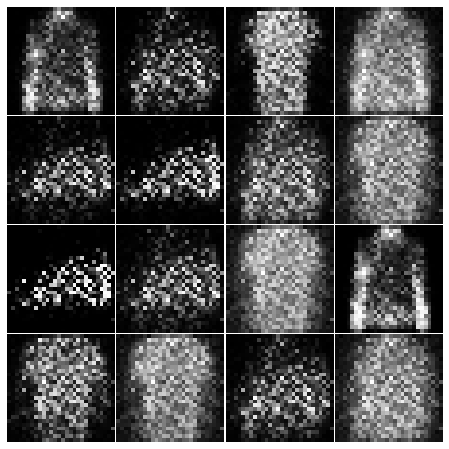

Epoch: 16/20 Losses:
Discriminator: 0.2530; Generator: 4.3603
D(x): 0.9268; D(G(z)): 0.0706


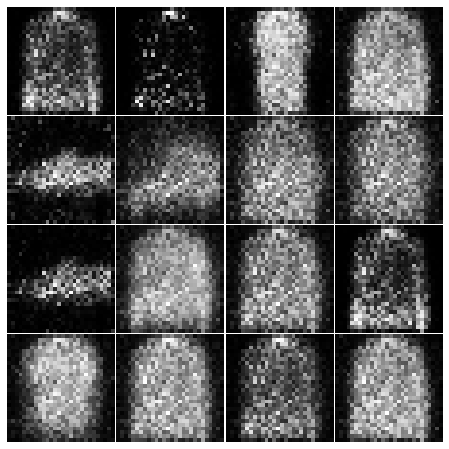

Epoch: 17/20 Losses:
Discriminator: 0.2179; Generator: 3.9341
D(x): 0.9159; D(G(z)): 0.0417


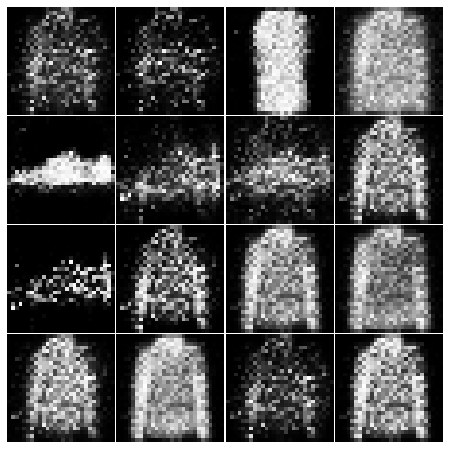

Epoch: 18/20 Losses:
Discriminator: 0.4315; Generator: 3.3477
D(x): 0.8997; D(G(z)): 0.1928


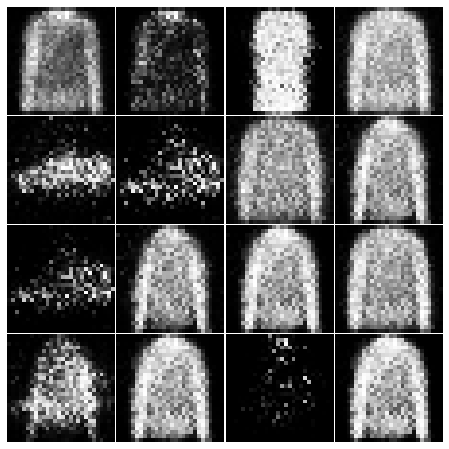

Epoch: 19/20 Losses:
Discriminator: 0.6194; Generator: 3.2110
D(x): 0.7735; D(G(z)): 0.0950


In [ ]:
num_epochs = 20
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for realbatch, _ in dataloader:
    real_data = images_to_vectors(realbatch).to(device)

    fake_data = generator(
        noise(real_data.size(0))
    )

    d_error, dpred_real, dpred_fake = (
        train_discriminator(d_optimizer, 
                        real_data, fake_data))
    
    fake_data = generator(noise(realbatch.size(0)))
    g_error = train_generator(g_optimizer, fake_data)

  # Show generated images
  imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
  test_images = vectors_to_images(generator(test_noise)).cpu().detach().numpy()
  log_images(test_images, imagepath)
  
  # Display status Logs
  G_losses.append(g_error)
  D_losses.append(d_error)
  print(f"Epoch: {epoch}/{num_epochs} Losses:")
  print(f"Discriminator: {d_error:.4f}; Generator: {g_error:.4f}")
  print(f"D(x): {dpred_real.mean():.4f}; D(G(z)): {dpred_fake.mean():.4f}")
  

# Visualizando os resultados

In [ ]:
def plot_losses(losses):
  fig = plt.figure(figsize=(16, 8))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    loss_values = [k.item() for k in loss_values]  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

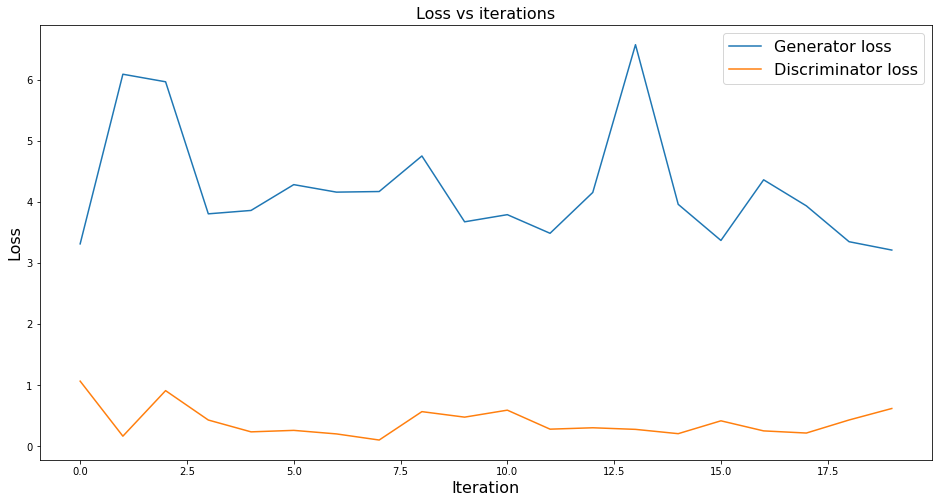

In [ ]:
plot_losses({"Generator loss": G_losses, 
             "Discriminator loss": D_losses})

In [ ]:
import imageio

In [ ]:
images = []
for filename in sorted(os.listdir(IMG_DIR), key = lambda x: float(x.split('.')[0])):
    if filename.endswith('.jpg'):
        filepath = os.path.join(IMG_DIR, filename)
        images.append(imageio.imread(filepath))
imageio.mimsave('fashion_training.gif', images)

# Onde buscar mais?

* DCGAN
* ProGAN
* Deep Learning with PyTorch